<a href="https://colab.research.google.com/github/kyochanpy/Google_Smartphone_Decimeter_Challenge/blob/main/PP/remove_device_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from glob import glob

In [34]:
def get_groundtruth(path: Path) -> pd.DataFrame:
    output_df = pd.DataFrame()
    
    for path in glob(str(path / 'train/*/*/ground_truth.csv')):
        _df = pd.read_csv(path)
        output_df = pd.concat([output_df, _df])
    output_df = output_df.reset_index(drop=True)
    
    _columns = ['latDeg', 'lngDeg', 'heightAboveWgs84EllipsoidM']
    output_df[['t_'+col for col in _columns]] = output_df[_columns]
    output_df = output_df.drop(columns=_columns, axis=1)
    return output_df

In [35]:
def calc_haversine(lat1, lon1, lat2, lon2):
    """Calculates the great circle distance between two points
    on the earth. Inputs are array-like and specified in decimal degrees.
    """
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(a**0.5)
    dist = 6_367_000 * c
    return dist

In [36]:
def check_score(input_df: pd.DataFrame) -> pd.DataFrame:
    output_df = input_df.copy()
    
    output_df['meter'] = input_df.apply(
        lambda r: calc_haversine(
            r.latDeg, r.lngDeg, r.t_latDeg, r.t_lngDeg
        ),
        axis=1
    )

    meter_score = output_df['meter'].mean()
    print(f'error meter: {meter_score}')

    scores = []
    for phone in output_df['phone'].unique():
        _index = output_df['phone']==phone
        p_50 = np.percentile(output_df.loc[_index, 'meter'], 50)
        p_95 = np.percentile(output_df.loc[_index, 'meter'], 95)
        scores.append(p_50)
        scores.append(p_95)

    score = sum(scores) / len(scores)
    print(f'score: {score}')
    
    return output_df

In [37]:
base = Path('/content/drive/MyDrive/GSDC')
train_base = pd.read_csv(base / 'baseline_locations_train.csv')
test_base = pd.read_csv(base / 'baseline_locations_test.csv')

# merge graoundtruth
train_base = train_base.merge(
    get_groundtruth(base),
    on=['collectionName', 'phoneName', 'millisSinceGpsEpoch']
)
sub = pd.read_csv(base / 'sample_submission.csv')
train_base = check_score(train_base)

error meter: 3.846848374990627
score: 5.287970649084159


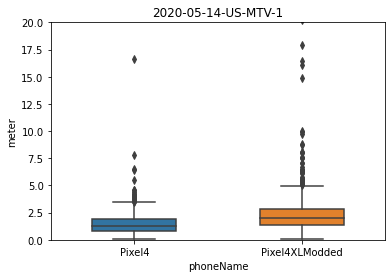

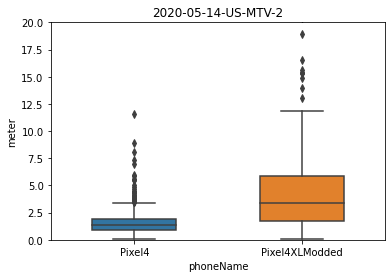

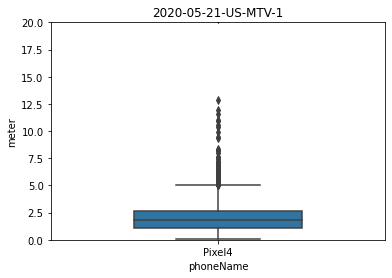

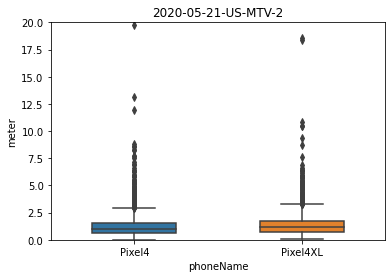

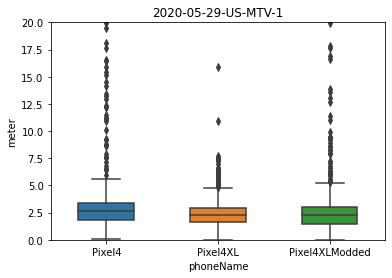

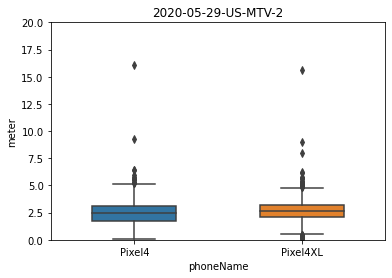

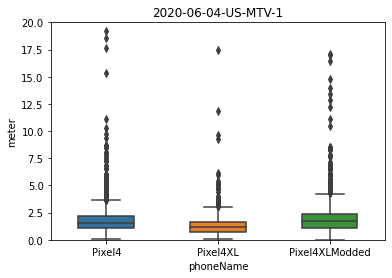

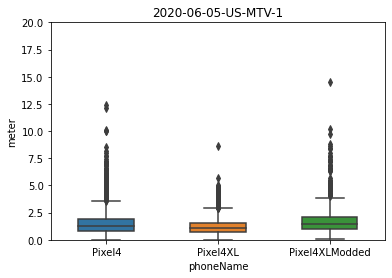

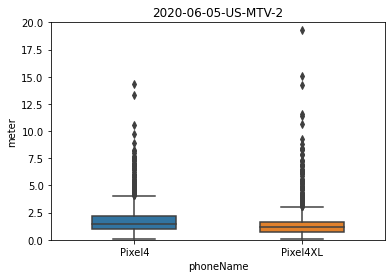

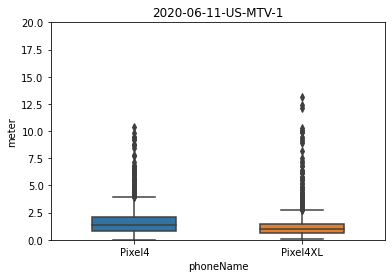

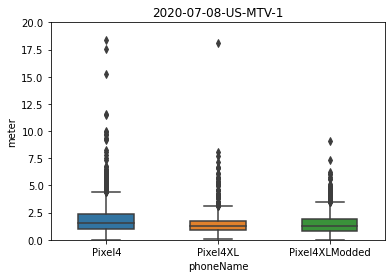

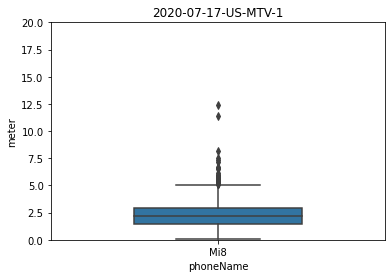

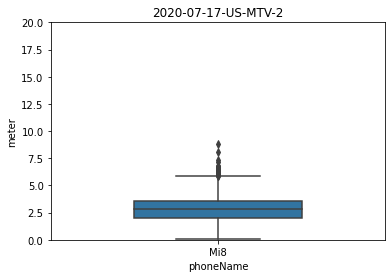

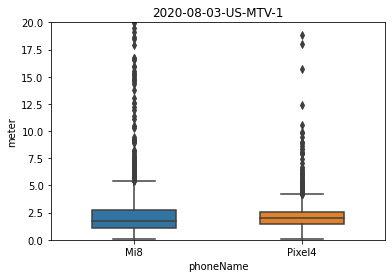

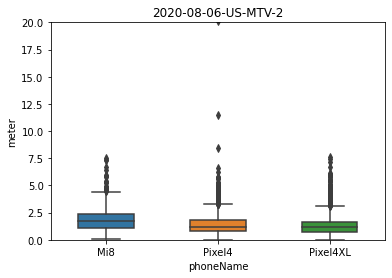

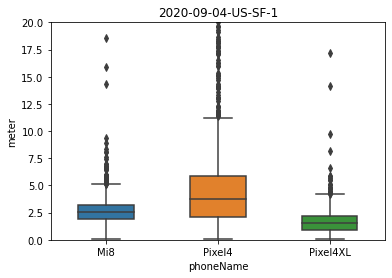

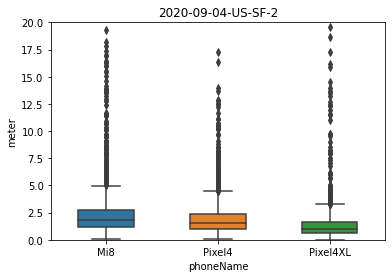

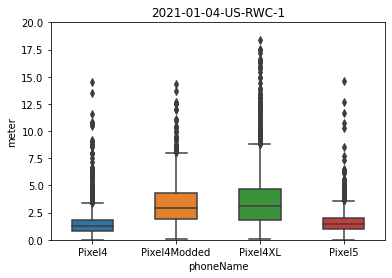

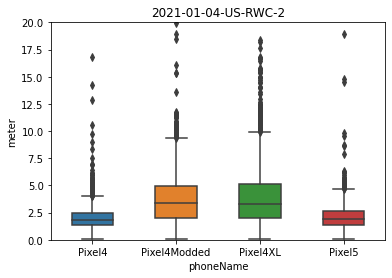

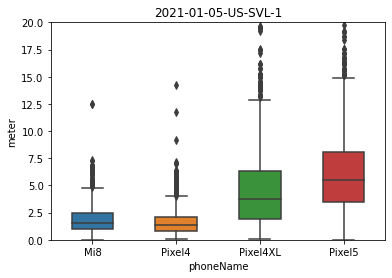

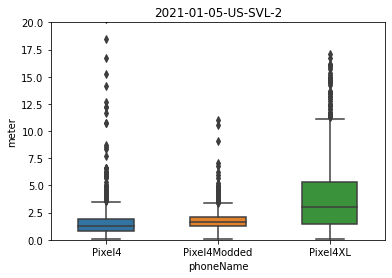

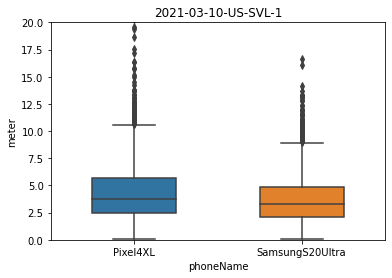

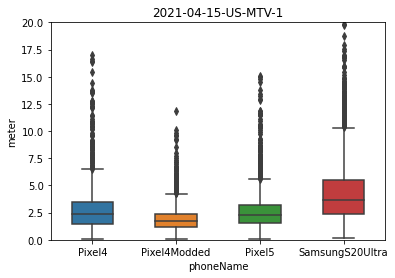

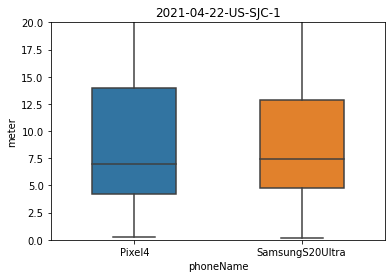

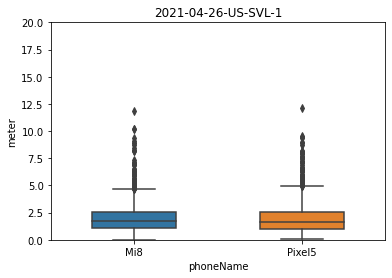

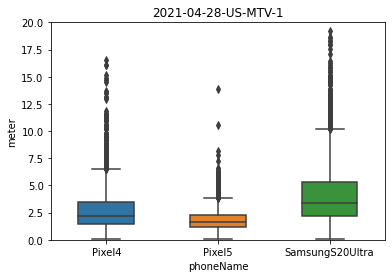

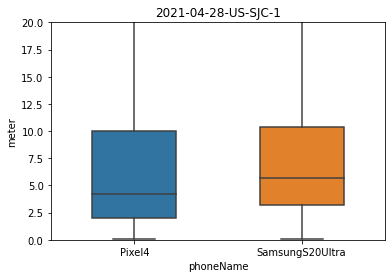

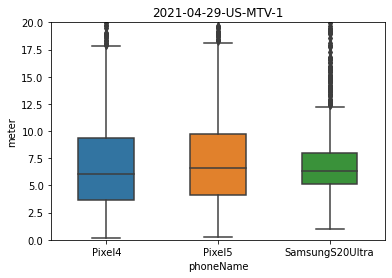

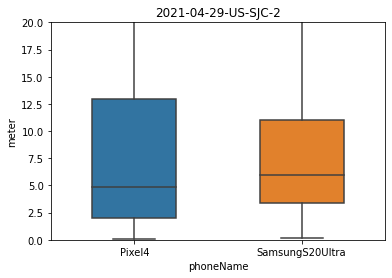

In [7]:
for name, df in train_base.groupby('collectionName'):    
    sns.boxplot(data=df, x='phoneName', y='meter', width=0.5)
    plt.title(name)
    plt.ylim(0, 20)
    plt.show()

In [19]:
for name, df in train_base.groupby('collectionName'):
    print(name)
    print(df)    
    print("---------------------------------------")

2020-05-14-US-MTV-1
           collectionName  ...      meter
0     2020-05-14-US-MTV-1  ...   3.586842
1     2020-05-14-US-MTV-1  ...   2.745901
2     2020-05-14-US-MTV-1  ...   1.888409
3     2020-05-14-US-MTV-1  ...   1.213483
4     2020-05-14-US-MTV-1  ...   1.650722
...                   ...  ...        ...
3481  2020-05-14-US-MTV-1  ...   8.681285
3482  2020-05-14-US-MTV-1  ...  16.457136
3483  2020-05-14-US-MTV-1  ...   7.037264
3484  2020-05-14-US-MTV-1  ...  21.234454
3485  2020-05-14-US-MTV-1  ...   3.239833

[3486 rows x 16 columns]
---------------------------------------
2020-05-14-US-MTV-2
           collectionName  ...     meter
3486  2020-05-14-US-MTV-2  ...  1.852975
3487  2020-05-14-US-MTV-2  ...  1.107463
3488  2020-05-14-US-MTV-2  ...  0.492590
3489  2020-05-14-US-MTV-2  ...  1.900480
3490  2020-05-14-US-MTV-2  ...  5.997859
...                   ...  ...       ...
5828  2020-05-14-US-MTV-2  ...  3.028577
5829  2020-05-14-US-MTV-2  ...  6.832099
5830  2020-05-14-US-M

In [47]:
remove_list = []
for name, df in train_base.groupby('collectionName'):
    phones_list = df["phoneName"].unique().tolist()
    meter_list = []

    if (len(phones_list) == 1):
            remove_list.append('dont_remove')
            continue

    for phone in phones_list:
        phone_df = df[df["phoneName"] == phone]
        phone_df['meter'] = phone_df.apply(lambda r: calc_haversine(r.latDeg, r.lngDeg, r.t_latDeg, r.t_lngDeg),axis=1)
        meter_score = phone_df['meter'].mean()
        meter_list.append(meter_score)
    remove_meter = sorted(meter_list)[-1]
    remove_idx = meter_list.index(remove_meter)
    remove_list.append(phones_list[remove_idx])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [72]:
len(remove_list)

29

In [129]:
def get_removedevice(input_df):
    input_df['index'] = input_df.index
    input_df = input_df.sort_values('millisSinceGpsEpoch')
    input_df.index = input_df['millisSinceGpsEpoch'].values
    sub_list = list(input_df["collectionName"].unique())

    output_df = pd.DataFrame() 
    for i, subdf in input_df.groupby('collectionName'):

        phones = subdf['phoneName'].unique()
        sub_idx = sub_list.index(i)
        device = remove_list[sub_idx-1]

        if (len(phones) == 1) or (not device in phones):
            output_df = pd.concat([output_df, subdf])
            continue

        origin_df = subdf.copy()
        
        _index = subdf['phoneName']==device
        subdf.loc[_index, 'latDeg'] = np.nan
        subdf.loc[_index, 'lngDeg'] = np.nan
        subdf = subdf.interpolate(method='index', limit_area='inside')

        _index = subdf['latDeg'].isnull()
        subdf.loc[_index, 'latDeg'] = origin_df.loc[_index, 'latDeg'].values
        subdf.loc[_index, 'lngDeg'] = origin_df.loc[_index, 'lngDeg'].values

        output_df = pd.concat([output_df, subdf])

    output_df.index = output_df['index'].values
    output_df = output_df.sort_index()

    del output_df['index']
    
    return output_df

In [130]:
train_remove = get_removedevice(train_base)

In [131]:
train_remove = check_score(train_remove)

error meter: 3.7458118512152163
score: 5.178682402515008


In [134]:
submission = pd.read_csv('/content/submission_07.csv')
submission['collectionName'] = submission['phone'].map(lambda x: x.split('_')[0])
submission['phoneName'] = submission['phone'].map(lambda x: x.split('_')[1])
submission = get_removedevice(submission)

submission = submission.drop(columns=['collectionName', 'phoneName'], axis=1)
submission.to_csv('submission_09.csv', index=False)